# EE603 Coding Assignment
- Use python3
- Submit your "rendered" ipynb, i.e., with outputs of codes (plots and printed values) visible below
- Do not change the return variables, as the evaluation is done by test cases based on the variables specified. Only add your code at "### WRITE YOUR CODE HERE"
- Use only numpy and librosa library for computing and signal processing, no other package allowed
- If you are using your mobile phone, you can use colab.research.google.com for coding
- Do not define multiple functions using same name. We will be using eval.py to auto evaluate your codes. Please check with sample test cases before submitting. We will share the evaluation test cases with you after the submission deadline.
- While submitting this file, change file name from 'YourRollNo.ipynb' to your actual roll no (Eg. 18204279.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
# from audio_proc_utils import *

/home/rbaijal/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import glob
def readDir(dirname, Fs = 22050):
    
    '''
    Each audio clip should be upto 10s long; split larger audio files into many clips (non-overlapping) 

    Use load_audio(file) 
    
    Inputs: 
        dirname: (str) directory name
        Fs: (int) sampling rate
    Output: 
        x: np arrays of shape (Nclips, Nsamples) Nsamples correspond to 10s length. Use zero-padding for shorter clips.
    '''  


    ### WRITE YOUR CODE HERE - 5 MARKS
    required_duration = 10
    x = np.zeros(required_duration*Fs)
    
    for path in glob.iglob(f'{dirname}/*.wav'):
        audio = load_audio(path, Fs)
        num_per_clip = Fs*required_duration   # Number of point samples for 10s audio clip
        N = (int)(audio.shape[0]/num_per_clip)
        for i in range(0, N):
            x = np.vstack((x, audio[i*num_per_clip : (i+1)*num_per_clip]))
         
        # Last audio sample must be zero padded
        if(audio.shape[0]%num_per_clip != 0):
            seq = audio[N*num_per_clip:]
            seq = librosa.util.fix_length(seq, required_duration*Fs)
            x = np.vstack((x, seq))

    # We need to skip the initial zero array which was added for convenience
    x = x[1:, :]           # Nclips x Nsamples
    
    return x 

In [3]:
def load_audio(filename, Fs = 22050):
    '''
    Inputs: 
        filename: (str) filename
        Fs: (int) sampling rate
    Output: 
        x: 1D np array 
    '''
    

    ### WRITE YOUR CODE HERE - 2 MARKS
    x, sr = librosa.load(filename, sr=Fs)
    
    return x

In [4]:
def splitData(X, t, testFraction=0.2, randomize = False):
    """
    Split the data randomly into training and test sets
    Use numpy functions only
    Inputs:
        X: (np array of len Nclips) input feature vectors
        t: (np array of len Nclips) targets; one hot vectors
        testFraction: (float) Nclips_test = testFraction * Nclips
    Outputs:
        X_train: training set
        X_test: test set
        t_train: training labels
        t_test: test labels
    """


    ### WRITE YOUR CODE HERE - 5 MARKS
    np.random.seed(0)
    test_size = (int)(testFraction * X.shape[0])
    indices = np.random.permutation(X.shape[0])
    training_index, test_index = indices[:X.shape[0] - test_size], indices[X.shape[0] - test_size:]
    X_train, t_train = X[training_index, :], t[training_index, :]
    X_test, t_test = X[test_index, :], t[test_index, :]

    return X_train, t_train, X_test, t_test

In [5]:
def audio2mfcc(x, n_mfcc = 13, Fs = 22050):
    
    '''
    Compute Mel-frequency cepstral coefficients (MFCCs)
    Inputs:
        x: np array of shape (Nclips,)
        Fs: (int) sampling rate
        n_mfcc: (int) number of MFCC features
    Output:
        X: (np array) MFCC sequence
    '''

    ### WRITE YOUR CODE HERE - 3 MARKS
    X = []
    for i in range(len(x)):
        mfccs = librosa.feature.mfcc(y=x[i], sr=Fs, n_mfcc=n_mfcc, hop_length=512)
        X.append(mfccs)
            
#     X = np.concatenate(X)
    X = np.stack(X, axis=0) # 3D array => Nsample 2D arrays of MFCCs
#     print("mfcc feat : ", X.shape)

    return X                # (Nclips, N_mfcc, N_frames)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=20, output_size=3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16).double()
        self.fc2 = nn.Linear(16,8).double()
        self.fc3 = nn.Linear(8, output_size).double()
        
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
#         X = F.relu(self.fc3(X))
        X = self.fc3(X)
        return F.softmax(X, dim=1)
        

In [7]:
Fs= 16000
n_mfcc = 20

# Read audio
x_music = readDir('music_speech/music_wav', Fs)    #change it as per your directory
x_speech = readDir('music_speech/speech_wav', Fs)  #change it as per your directory
x_silence = readDir('music_speech/silence_wav', Fs)
X = np.concatenate((x_music, x_speech, x_silence))

# Create labels
y_music = np.array([[1,0,0]]*len(x_music))
y_speech = np.array([[0,1,0]]*len(x_speech))
y_silence = np.array([[0,0,1]]*len(x_silence))
Y = np.concatenate((y_music, y_speech, y_silence))

X_train, y_train, X_test, y_test = splitData(X, Y)

In [8]:
y_train.shape, y_test.shape
# len(x_music)

((484, 3), (120, 3))

In [9]:
x_train = audio2mfcc(X_train, n_mfcc, Fs)    # x_train: (Nclips, N_mfcc, N_frames)

In [10]:
x_train[0, :, 0]

array([-3.62404810e+02, -9.59441690e+00,  1.92484050e+00,  3.29801755e+00,
        5.03028112e+00,  4.32729956e+00,  1.50348919e+00, -2.32773538e+00,
       -8.00684000e-01,  6.42092386e+00,  6.60659223e-01, -5.11414101e-02,
        2.22370958e-01, -6.04568005e-01,  4.21715555e+00,  2.16409594e+00,
        5.54843932e+00,  8.48662229e+00,  3.39078507e+00, -2.16044697e+00])

In [11]:
x_train = torch.from_numpy(x_train)

In [12]:
y_train = torch.from_numpy(y_train)

In [13]:
x_test = audio2mfcc(X_test, n_mfcc, Fs) 

In [14]:
x_test = torch.from_numpy(x_test)

In [15]:
y_test = torch.from_numpy(y_test)

In [16]:
torch.manual_seed(0)
model = NeuralNetwork()

In [17]:
print(x_train.shape)
x_train = x_train.permute(0,2,1)
# x = x.permute(1,0)
print(x_train.shape)
x_train = x_train.type(torch.DoubleTensor)

torch.Size([484, 20, 313])
torch.Size([484, 313, 20])


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
y_pred = model(x_train[0])

In [20]:
y = y_train[0].repeat(5,1)
y

tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]])

In [21]:
y1 = torch.max(y_pred.data, 1)[1]

In [22]:
torch.max(y_pred.data, 1)[1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
x_test = x_test.permute(0,2,1)
x_test.shape

torch.Size([120, 313, 20])

In [24]:
import time
start_time = time.time()

epochs = 100
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for e in range(epochs):
    train_corr = 0
    batch_corr = 0
    
    test_corr = 0
    num_clips = x_train.shape[0]
    num_frames = x_train.shape[1]
    
    epoch_loss = 0
    
    for i in range(x_train.shape[0]):
        y_pred = model(x_train[i])
        
        
        num_frames = x_train[i].shape[0]
        y = y_train[i].repeat(num_frames,1)
        
        y = torch.max(y, 1)[1]
        predicted = torch.max(y_pred, 1)[1]
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        batch_corr = (predicted == y).sum()
        train_corr += batch_corr
        
        epoch_loss += loss.item()
#         train_losses.append(loss)
    train_losses.append(epoch_loss/ num_clips)
    train_correct.append(train_corr/(num_clips*num_frames))
    
    with torch.no_grad():
        l = 0
        for i in range(x_test.shape[0]):
            y_pred = model(x_test[i])
            
            num_frames = x_test[i].shape[0]
            y = y_test[i].repeat(num_frames, 1)
            y = torch.max(y, 1)[1]
            
            predicted = torch.max(y_pred,1)[1]
            loss = criterion(y_pred, y)
            
            test_corr += (predicted == y).sum()
            l += loss.item()
        
        test_losses.append(l / x_test.shape[0])
        test_correct.append(test_corr/ (x_test.shape[0] * x_test.shape[1]))
    print(f'epoch : {e} accuracy : {test_correct[-1]}')

epoch : 0 accuracy : 0.6784344911575317
epoch : 1 accuracy : 0.6812566518783569
epoch : 2 accuracy : 0.6823216080665588
epoch : 3 accuracy : 0.6826145052909851
epoch : 4 accuracy : 0.5827209949493408
epoch : 5 accuracy : 0.7701277732849121
epoch : 6 accuracy : 0.825798749923706
epoch : 7 accuracy : 0.8465654850006104
epoch : 8 accuracy : 0.8557241559028625
epoch : 9 accuracy : 0.861687958240509
epoch : 10 accuracy : 0.8669062852859497
epoch : 11 accuracy : 0.8712459802627563
epoch : 12 accuracy : 0.8747603893280029
epoch : 13 accuracy : 0.877103328704834
epoch : 14 accuracy : 0.8793929815292358
epoch : 15 accuracy : 0.8828541040420532
epoch : 16 accuracy : 0.8844515681266785
epoch : 17 accuracy : 0.886448323726654
epoch : 18 accuracy : 0.8890042304992676
epoch : 19 accuracy : 0.8906815648078918
epoch : 20 accuracy : 0.8929446339607239
epoch : 21 accuracy : 0.8948349356651306
epoch : 22 accuracy : 0.8961395025253296
epoch : 23 accuracy : 0.8968849778175354
epoch : 24 accuracy : 0.897630

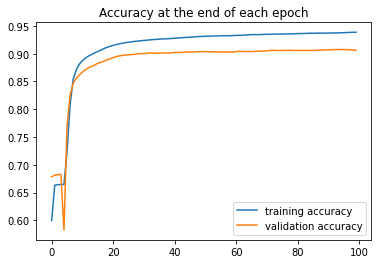

In [25]:
plt.plot(train_correct, label='training accuracy')
plt.plot(test_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

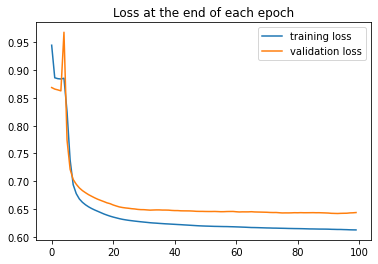

In [26]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [27]:
# torch.save(model.state_dict(), 'NN.pth')

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
Y_pred = []
Y = []

with torch.no_grad():
    l = 0
    for i in range(x_test.shape[0]):
        y_pred = model(x_test[i])
            
        num_frames = x_test[i].shape[0]
        y = y_test[i].repeat(num_frames, 1)
        y = torch.max(y, 1)[1]
            
        predicted = torch.max(y_pred,1)[1]
        
#         Y_pred = np.vstack((Y_pred, predicted))
        Y_pred += (np.array(predicted)).tolist()
        Y += (np.array(y)).tolist()

print(len(Y), len(Y_pred))

37560 37560


In [30]:
c = Y_pred

In [31]:
cm = confusion_matrix(Y, Y_pred)
cm

array([[13416,  2230,     4],
       [ 1297, 10595,     2],
       [    0,     1, 10015]])

<AxesSubplot:>

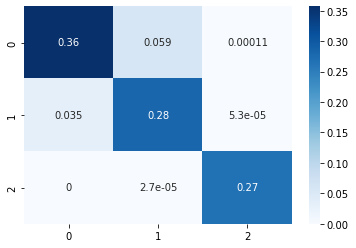

In [32]:
import seaborn as sns
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues')

In [33]:
# loaded_model = NeuralNetwork()
# loaded_model.load_state_dict(torch.load('NN.pth'))
# loaded_model.eval()

In [34]:
# Y_pred = []
# Y = []

# with torch.no_grad():
#     l = 0
#     for i in range(x_test.shape[0]):
#         y_pred = loaded_model(x_test[i])
            
#         num_frames = x_test[i].shape[0]
#         y = y_test[i].repeat(num_frames, 1)
#         y = torch.max(y, 1)[1]
            
#         predicted = torch.max(y_pred,1)[1]
        
# #         Y_pred = np.vstack((Y_pred, predicted))
#         Y_pred += (np.array(predicted)).tolist()
#         Y += (np.array(y)).tolist()

# print(len(Y), len(Y_pred))

NameError: name 'loaded_model' is not defined